## 作业四

作业四是对seq2seq模型的一个有趣的应用。Seq2seq模型可以用学习从序列到序列的转换，而序列到序列转换的任务有很多。在作业四里，使用seq2seq模型来学习两位整数的加减法。虽然使用计算机进行数值计算是很容易的任务，但是如果让计算机以“自然语言处理”的方式来计算则很有挑战性。加减法的算式可以视为一个输入文本，如`'1+99'`，而结果也可以视为一个输出文本，例如`'100'`。我们希望模型可以输入代表算式的字符串，输出代表结果的字符串。在这里，输入与输出都有可变的长度，且都具有时序特征，适合使用seq2seq模型。

针对上面的需求，实验的框架为：
1. 随机生成一定数量的算式作为语料。包括：
    * 生成用于计算的数字、符号及对应的结果。
    * 算式等号左边与右边的内容分别转成文本。
    * 对不同长度的文本，补齐到最大长度。
    * 以文本中所涉及的符号得到词典。
    * 应用此词典把输入、输出序列中的token转为编号。


2. 将此语料整理为seq2seq模型可使用的数据。
    * 将语料样本集包装为`Dataloader`对象，其在训练过程中提供batch的数据。


3. 对模型进行训练并测试。


作业以补全代码形式完成。我们使用第14周课上的包来实现，因此需将数据集处理为与其兼容的形式。我们通过定义类`DataGen`来生成数据。需补全的代码也主要在这一部分。

* 首先生成一个词典`self.vocab`，包含算式里所有可能出现的字符，为Vocab对象，其作用为将输入的tokens转为对应的编号。例如将 `['1', '+', '1']` 转换为 `[6, 3, 6]` 。Vocab对象具有`idx_to_token`与`token_to_idx`属性。`idx_to_token`与`token_to_idx`都是字典类型，`idx_to_token`的key是每个字符的序号，value是每个字符；`token_to_idx`的key是每个字符，value是每个字符的序号。**这里需要补全代码**。

* 其次随机生成加减法的样本集，得到用于计算的数据、符号（'+'或者'-'）与结果。再将生成的算式转为文本，在`DataGen`的`equation_to_text()`函数中实现，**这里需要补全代码**。每个式子末尾加上`'<eos>'`，并且由于每个式子的长度不同，需将句子末尾使用`'<pad>'`符号来填充。**这里需要补全代码**。

* 最后将转为字符序列的样本转换为`tensor`，并使用torch本身的`TensorDataset``DataLoader`来得到数据的加载器`loader`作为数据集生成的结果，以`DataGen.generate()`函数返回。

* 调用`tran_calculator()`和`predict_calculator()`进行训练和预测。这两个函数都已在`nets.py`中实现，注意将模块导入。**这里需要补全代码**。

0+0 => 0
99+99 => 195
1+99 => 100
0-99 => -99


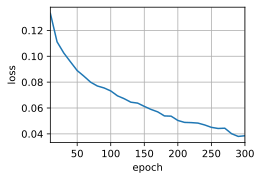

In [9]:
# -*- coding: utf-8 -*-

import numpy as np
import torch
import os
from torch.utils.data import TensorDataset, DataLoader
from d2l import torch as d2l
from nets import Seq2SeqEncoder, Seq2SeqDecoder, MaskedSoftmaxCELoss, train_calculator, predict_calculator

'''
从nets模块中导入模型训练的函数train_calculator()和测试的函数predict_calculator()
##########
'''
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


class Vocab(object):
    def __init__(self, symbols):        
        '''
        Vocab对象具有 idx_to_token 与 token_to_idx 属性。
        idx_to_token 与 token_to_idx 都是字典类型。
        idx_to_token 的 key 是每个字符的序号，value 是每个字符；
        token_to_idx 的 key 是每个字符，value 是每个字符的序号。
        其作用是把 token 与对应的编号相互转换，例如将 ['1', '+', '1'] 转换为 `[6, 3, 6]` 。
        
        self.idx_to_token = ##########
        self.token_to_idx = ##########  
        '''
        self.idx_to_token = dict(zip([i for i in range(len(symbols))],symbols))
        self.token_to_idx = dict(zip(symbols,[i for i in range(len(symbols))]))
        
       
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, 'unknown')
        return [self.__getitem__(token) for token in tokens]

class DataGen(object):
    def __init__(self, digits):        
        self.digits = digits # __init__()的参数为数字的位数，这里取2。
        self.in_steps = digits * 2 + 3 # 输入式子最大长度
        self.out_steps = digits + 3 # 输出式子最大长度
        symbols = ['<pad>','<bos>','<eos>','+','-'] + [str(i) for i in range(10)] # 计算用到的所有符号
        self.vocab = Vocab(symbols)     
    
    def equation_to_text(self, data, sign, result):
        
        # 所有的算式为 a+b=c 或者 a-b=c，等号左边为输入序列，等号右边为输出序列。
        t1 = [str(a) for a in data[:,0]] 
        t2 = ['+' if s == 1 else '-' for s in sign]
        t3 = [str(b) for b in data[:,1]]
        t4 = [str(c) for c in result]
        
        left = [''.join(t) for t in list(zip(t1, t2, t3))] # 输入式子       
        left = [[l for l in t] + ['<eos>'] for t in left] # 输入式子末尾加上'<eos>'
        left_len = [len(line) for line in left] # 输入式子长度
        
        '''
        为每个输入式子结尾补全'<pad>'，使得总长度为self.in_steps
        
        left = ##########
        '''
        left = [[l for l in t] + ['<pad>']*(self.in_steps - len([l for l in t])) for t in left ]
        
        right = [[l for l in t] + ['<eos>'] for t in t4] # 输出式子末尾加上'<eos>'
        right_len = [len(line) for line in right] # 输出式子长度
    
        '''
        为每个输出式子结尾补全'<pad>'，使得总长度为self.out_steps
        
        right = ##########
        '''
        right = [[r for r in t] + ['<pad>']*(self.out_steps - len([r for r in t])) for t in right ]

        return left, left_len, right, right_len
        
    def generate(self, batch_size): 
        data_size = 10000
        np.random.seed(2022)
        data = np.random.randint(int(10**self.digits), size=(data_size,2)) # 生成数据，计算加减法的两个数字
        sign = np.random.choice((1,-1), size=[data_size]) # 随机指定加减法
        result = data[:,0] + sign * data[:,1] # 得到结果
        
        '''
        调用equation_to_text()函数，把上面随机生成的算式转成文本
        
        left, left_len, right, right_len = ##########
        '''
        corpus = self.equation_to_text(data, sign, result)
        left = corpus[0]
        left_len = corpus[1]
        right = corpus[2]
        right_len = corpus[3]

        data_left = [self.vocab[line] for line in left] # 输入文本从符号转为编号
        data_left_len = left_len
        data_right = [self.vocab[line] for line in right] # 输出文本从符号转为编号
        data_right_len = right_len
        
        data_arrays = [torch.tensor(i) \
                for i in [data_left, data_left_len, data_right, data_right_len]]        
        dataset = TensorDataset(*data_arrays)
        loader = DataLoader(dataset, batch_size, shuffle=True) # 将数据集包装为DataLoader对象
        
        return loader, self.vocab, self.vocab
               
    
if __name__ == '__main__':
    
    embed_size, num_hiddens, num_layers, dropout = 16, 64, 2, 0.1
    batch_size, num_steps = 64, 7
    lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

    gen = DataGen(2) # 样本生成器，参数为数字的位数，这里取2。
    train_iter, src_vocab, tgt_vocab = gen.generate(batch_size) # 生成数据集自动加载batch数据
    
    # 实例化 seq2seq 的 encoder
    encoder = Seq2SeqEncoder(
        len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
    # 实例化 seq2seq 的 decoder
    decoder = Seq2SeqDecoder(
        len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    
    net = d2l.EncoderDecoder(encoder, decoder) # 实例化一个seq2seq模型   
    if os.path.exists('./net.pth'): # 如果有预训练的模型文件，则加载模型文件 
        net.load_state_dict(torch.load('./net.pth'))
    
    train_calculator(net, train_iter, lr, num_epochs, tgt_vocab, device) # 训练模型
    
    # torch.save(net.state_dict(), 'net.pth') # 保存模型
    
    # 测试模型
    inputs = ['0+0', "99+99", '1+99', '0-99']
    outputs = ['0', '198', '100', '-10']
    for left, right in zip(inputs, outputs):
        result = predict_calculator(
            net, left, src_vocab, tgt_vocab, num_steps, device)
        print(f'{left} => {result}')
